In [1]:
import numpy as np
from string import punctuation
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score

/Users/ebriakou/opt/anaconda3/envs/playground/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
div_to_color = {'3': '#FF7F50',
                '2': '#FFBF00', 
                '1': '#DFFF00',
                '0': '#FFFFFF'}

def color_html(label):
    return f'<span style="background-color:{div_to_color[label]} ">'

def display_HTML(text, div):
    displayed_text = ''
    previous = 'eq'
    mark_end = '</span>'
    for token, label in zip(text.split(' '), div.split(' ')):
        mark = color_html(label)
        print(label)
        if label == '0':
            displayed_text += f' {token}'
            previous = 'eq'
        else:
            if previous == 'div':
                displayed_text += f'{mark} {token}{mark_end}'
            else:
                displayed_text += f' {mark}{token}{mark_end}'
            previous = 'div'
        
    return display(HTML(displayed_text))

In [17]:
import string
punctuation_types = [punc for punc in string.punctuation]
excluded_types = punctuation_types + ['-LRB-', '-RRB-', 'DT', 'IN', '``', 'HYPH', 'CC', 'TO', 'PUNCT', 'DET', 'CCONJ' ]


def add_lists(list_a, list_b):
    #print(list_b)
    #print(list_a)
    #print('as')
    list_add = []
    for (a, b) in zip(list_a, list_b):
        list_add.append(a+b)
    return list_add

def filter_pos(gold, model, pos):
    gold_new, model_new = [],[]
    for id_, p in enumerate(pos.rstrip().split(' ')):
        if p == 'PUNC' or p in excluded_types:
            continue
        gold_new.append(gold[id_])
        model_new.append(model[id_])
    return gold_new, model_new

def compute_ap_score(gold_explanations, model_explanations, pos):
    res = 0
    all_pre = []
    norm_ = 0
    if pos:
        for i in range(len(gold_explanations)):
            if sum(model_explanations[i]) ==0:
                continue
            if sum(gold_explanations[i]) != 0 and sum(gold_explanations[i]) != len(gold_explanations[i]):
                norm_ += 1
                
                gold, model = filter_pos(gold_explanations[i], model_explanations[i], pos[i])
                #print(f'{len(gold_explanations[i])} {len(gold)} ')
                all_pre.append(precision_score(gold, model))
                if sum(model)  == 0:
                    continue
                res += precision_score(gold, model)
    else:
        for i in range(len(gold_explanations)):
            if sum(model_explanations[i]) ==0:
                continue
            if sum(gold_explanations[i]) != 0 and sum(gold_explanations[i]) != len(gold_explanations[i]):
                norm_ += 1
                all_pre.append(precision_score(gold_explanations[i], model_explanations[i]))
                if sum(model_explanations[i])  == 0:
                    continue
                res += precision_score(gold_explanations[i], model_explanations[i])
    return res / norm_, all_pre


def compute_rec_topk(gold_explanations, model_explanations, pos):
    res = 0
    all_rec = []
    norm_ = 0
    if pos:
        print(len(gold_explanations))
        for i in range(len(gold_explanations)):
            print(sum(model_explanations[i]))
            if sum(model_explanations[i]) ==0:
                continue
            if sum(gold_explanations[i]) != 0 and sum(gold_explanations[i]) != len(gold_explanations[i]):
                gold, model = filter_pos(gold_explanations[i], model_explanations[i], pos[i])    
                all_rec.append(recall_score(gold, model))
                res += recall_score(gold, model)
                norm_ += 1
    else:
        for i in range(len(gold_explanations)):
            if sum(model_explanations[i]) ==0:
                continue
            #print(gold_explanations[i])
            if sum(gold_explanations[i]) != 0 and sum(gold_explanations[i]) != len(gold_explanations[i]):
                all_rec.append(recall_score(gold_explanations[i], model_explanations[i]))
                res += recall_score(gold_explanations[i], model_explanations[i])
                norm_ += 1
    return res / norm_, all_rec


def num_spans(labels):
    previous_label = 'E'
    unique_labels = []
    for label in labels:
        if previous_label == label:
            continue
        else:
            unique_labels.append(label)
        previous_label = label
    return sum(unique_labels)


def max_ngram(labels):
    previous_label = 'E'
    divergent_len = []
    count = 0
    for label in labels:
        if label == 1:
            count += 1
        else:
            divergent_len.append(count)
            count = 0
    divergent_len.append(count)
    return max(divergent_len)

In [18]:
src_pos_all, tgt_pos_all = [], []
with open('annotations/sd_inter_pos_both', 'r') as pos_:
    pos_ = pos_.readlines()
    for pos in pos_:
        pos = pos.rstrip().split('\t')
        src_pos_all.append(pos[-2])
        tgt_pos_all.append(pos[-1])

In [28]:
src_pos_all, tgt_pos_all = [], []

#for file_ in ['ro-en-test21_inter_divergentmBERT']:
for file_ in ['nd_missing_paired_pos_phrases_reward']:
    all_revisions, first_score, final_score, improved, edits_src, edits_tgt, g_edits_src, g_edits_tgt = [], [], [], 0, [], [], [], []
    src_edits_diff, tgt_edits_diff = [],[]
    random_src, random_tgt = [], []
    gold_explanations_src, model_explanations_src, gold_explanations_tgt, model_explanations_tgt = [], [], [], []
    original, masked = [], []
    with open(f'outputs/{file_}', 'r') as out_:
        threshold = 0.1
        c = 0
        lines = out_.readlines()
        for threshold_gold in [0]:
            tp_div, fp_div, fn_div, tp_eq, fp_eq, fn_eq = 0, 0, 0, 0, 0, 0 
            for line in lines:
                    if not line:
                        continue
                    c += 1
               
                    line = line.split('\t')
                    gold_a = np.array([float(x) for x in line[2].split(' ')])
                    gold_b = np.array([float(x) for x in line[3].split(' ')])
                    raw_a = np.array([float(x) for x in line[4].split(' ')])
                    raw_b = np.array([float(x) for x in line[5].split(' ')])
                    original_score = float(line[4])
                    
                    #if original_score > 0:
                    #    continue
                    #revisions = min(6, int(line[5]))
                    revisions = int(line[5])
                    all_revisions.append(revisions)
                    
                    previous_score = original_score
                    expl_a = [0] * len(gold_a)
                    expl_b = [0] * len(gold_b)
                    
                    
                    for i in range(revisions):                        
                        score = line[5 + 3*i + 1]
                        if i == 0:
                            first_score.append(score)
                        if float(score) - float(previous_score) < 1:
                            break
                        expl_a = add_lists(expl_a, [int(a) for a in line[5 + 3*i + 2].split(' ')])
                        expl_b = add_lists(expl_b, [int(a) for a in line[5 + 3*i + 3].split(' ')])
    
                        previous_score = score
     
     
                    final_score.append(score)
                    
                    if float(score) > original_score:
                        #print(f'{original_score} ||| {score}')
                        improved += 1
            
                    #if line[-1] == 'None\n':
                    #    continue

                    gold_a_ = np.where(gold_a > threshold_gold, 1, 0)
                    gold_b_ = np.where(gold_b > threshold_gold, 1, 0)
                    
                    if sum(gold_a_) ==0 and sum(gold_b_)==0:
                        #print(gold_a_)
                        continue

                    expl_a_ = np.where(np.array(expl_a) > 0, 1, 0)
                    expl_b_ = np.where(np.array(expl_b) > 0, 1, 0)
                    
                    edits_src.append(np.sum(expl_a_)/len(expl_a_))
                    edits_tgt.append(np.sum(expl_b_)/len(expl_b_))
                    
                                        
                    g_edits_src.append(np.sum(gold_a_)/len(gold_a_))
                    g_edits_tgt.append(np.sum(gold_b_)/len(gold_b_))
                    
                    src_edits_diff.append(np.sum(expl_a_) - np.sum(gold_a_))
                    tgt_edits_diff.append(np.sum(expl_b_) - np.sum(gold_b_))
                    
                    gold_revisions =  num_spans(gold_b_)
                    #print(f'{revisions} {gold_revisions}')
                    #print(gold_b_)
                    #print(num_spans(gold_b_))
       
                    
                    
                    gold_explanations_src.append(list(gold_a_))
                    model_explanations_src.append(list(expl_a_))
                    random_src.append(list(np.random.randint(2, size=len(list(gold_a_)))))

                    gold_explanations_tgt.append(list(gold_b_))
                    model_explanations_tgt.append(list(expl_b_))
                    random_tgt.append(list(np.random.randint(2, size=len(list(gold_b_)))))

                    text_a = line[0].split(' ')
                    text_b = line[1].split(' ')

                    for text_id, (g, e) in enumerate(zip(gold_a_, expl_a)):
                        if text_a[text_id] in punctuation:
                            continue
                        # Equivelent
                        if g == 0:
                            if e == 0:
                                tp_eq +=1
                            else:
                                fp_div += 1
                                fn_eq += 1
                        else:
                            if e == 1:
                                tp_div +=1
                            else:
                                fp_eq += 1
                                fn_div += 1

                    for text_id, (g, e) in enumerate(zip(gold_b_, expl_b)):
                        if text_b[text_id] in punctuation:
                            continue
                        # Equivelent
                        if g == 0:
                            if e == 0:
                                tp_eq +=1
                            else:
                                fp_div += 1
                                fn_eq += 1
                        else:
                            if e == 1:
                                tp_div +=1
                            else:
                                fp_eq += 1
                                fn_div += 1

            #precision_eq = tp_eq / (tp_eq + fp_eq)
            #precision_div = tp_div / (tp_div + fp_div)

            #recall_eq = tp_eq / (tp_eq + fn_eq)
            #recall_div = tp_div / (tp_div + fn_div)

            #f1_eq = 2*(precision_eq * recall_eq) / (precision_eq + recall_eq)
            #f1_div = 2*(precision_div * recall_div) / (precision_div + recall_div)
            #f1_mul = f1_eq * f1_div
            #print("%.2f\t\t%.2f" % (precision_eq, precision_div))
            #print("%.2f\t\t%.2f" % (precision_eq, recall_div))
            #print("%.2f\t\t%.2f\t\t%.2f" % (f1_div, f1_eq, f1_mul))

            #print(gold_explanations[0])
            #print(model_explanations[0])
            rec_src, all_recall_src = compute_rec_topk(gold_explanations_src, model_explanations_src, pos=src_pos_all)
            ap_src, all_precision_src = compute_ap_score(gold_explanations_src, model_explanations_src, pos=src_pos_all)

            rec_tgt, all_recall_tgt = compute_rec_topk(gold_explanations_tgt, model_explanations_tgt, pos=tgt_pos_all)
            ap_tgt, all_precision_tgt = compute_ap_score(gold_explanations_tgt, model_explanations_tgt, pos=tgt_pos_all)
            print(f'\n ---{file_}')
            print(f'\n{ap_src}')
            print(f'{rec_src}')

            print(f'\n{ap_tgt}')
            print(f'{rec_tgt}')
            
            random_rec_src,_  = compute_rec_topk(gold_explanations_src, random_src, pos=src_pos_all)
            random_rec_tgt,_  = compute_rec_topk(gold_explanations_tgt, random_tgt, pos=tgt_pos_all)
            random_ap_src, _ = compute_ap_score(gold_explanations_src, random_src, pos=src_pos_all)
            random_ap_tgt, _ = compute_ap_score(gold_explanations_tgt, random_tgt, pos=tgt_pos_all)

print(f'\n ---random')
print(f'\nAP: {random_ap_src}')
print(f'REC: {random_rec_src}')

print(f'\nAP: {random_ap_tgt}')
print(f'REC: {random_rec_tgt}')


equivalized = len([i for i in final_score if float(i) > 0])/len(final_score)

print(f'\nEquivalized score: {equivalized*100}')
print(f'Improved score: {100*improved/len(final_score)}')
print(f'Revisions: {np.mean(all_revisions)}')
print(f'Src Edits: {np.mean(edits_src)*100}')
print(f'Tgt Edits: {np.mean(edits_tgt)*100}')

print(f'\nSrc Gold: {np.mean(g_edits_src)*100}')
print(f'Tgt Gold: {np.mean(g_edits_tgt)*100}')

print(f'\nSrc Diff: {np.mean(src_edits_diff)} {np.std(src_edits_diff)} ')
print(f'Tgt Diff: {np.mean(tgt_edits_diff)} {np.std(tgt_edits_diff)}')

#print(f'{ap_src}\t{rec_src}\t{ap_tgt}\t{rec_tgt}\t{equivalized*100}\t{100*improved/len(final_score)}\t{np.mean(all_revisions)}\t{np.mean(edits_src)*100}\t{np.mean(edits_src)*100}')


 ---nd_missing_paired_pos_phrases_reward

0.37166862256292504
0.44883547650140915

0.3893463998687879
0.38344757982881955

 ---random

AP: 0.1368809168720837
REC: 0.5128979017992469

AP: 0.15596560275800822
REC: 0.49302503413685256

Equivalized score: 98.1029810298103
Improved score: 99.7289972899729
Revisions: 2.962059620596206
Src Edits: 14.133124060725033
Tgt Edits: 13.672553117362732

Src Gold: 10.606504195576203
Tgt Gold: 14.301825087319154

Src Diff: 1.0 4.263866268488678 
Tgt Diff: -0.2326388888888889 5.318799596466908


## import seaborn as sns 
sns.distplot(src_edits_diff, kde=False)

<AxesSubplot:>

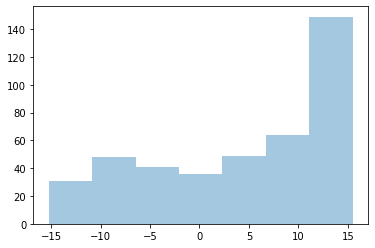

In [9]:
sns.distplot(final_score, kde=False)

In [26]:
from collections import defaultdict
model_explanations_src_all = defaultdict(list)
model_explanations_tgt_all = defaultdict(list)
num_edits_all = defaultdict(list)
final_scores_all = defaultdict(list)

files_ = ['missing_paired_phrases_filtering_ngrams_2', 'missing_paired_phrases_filtering_ngrams_3', 'missing_paired_phrases_filtering_ngrams_4', 'missing_paired_phrases_filtering_ngrams_5', 'missing_paired_phrases_filtering_ngrams_6', 'missing_paired_phrases_filtering_ngrams_7', 'missing_paired_phrases_filtering_ngrams_8', 'missing_paired_phrases_filtering_ngrams_9', 'missing_paired_phrases_filtering_ngrams_10', 'missing_paired_phrases_filtering' , 'missing_paired_phrases_filtering_2_3' , 'missing_paired_phrases'] 
files_ = ['missing_paired_pos_phrases_filtering_ngrams_2', 'missing_paired_pos_phrases_filtering_ngrams_3', 'missing_paired_pos_phrases_filtering_ngrams_4', 'missing_paired_pos_phrases_filtering_ngrams_5', 'missing_paired_pos_phrases_filtering_ngrams_6', 'missing_paired_pos_phrases_filtering_ngrams_7', 'missing_paired_pos_phrases_filtering_ngrams_8', 'missing_paired_pos_phrases_filtering_ngrams_9', 'missing_paired_phrases_filtering_ngrams_10', 'missing_paired_pos_phrases_filtering' , 'missing_paired_phrases_filtering_2_3' , 'missing_paired_pos_phrases'] 


#files_ = [ 'missing_paired_phrases_filtering_ngrams_4', 'missing_paired_phrases_filtering_ngrams_5', 'missing_paired_phrases_filtering_ngrams_6', 'missing_paired_phrases_filtering_ngrams_7', 'missing_paired_phrases_filtering_ngrams_8', 'missing_paired_phrases_filtering_ngrams_9', 'missing_paired_phrases_filtering_ngrams_10', 'missing_paired_phrases_filtering' , 'missing_paired_phrases_filtering_2_3' , 'missing_paired_phrases'] 


    


for file_ in files_:
#for file_ in [ 'missing_paired_phrases']:
#for file_ in ['missing_paired_parse_phrases_filtering_ngrams_2', 'missing_paired_parse_phrases_filtering_ngrams_3', 'missing_paired_parse_phrases_filtering_ngrams_4', 'missing_paired_parse_phrases_filtering_ngrams_5', 'missing_paired_parse_phrases_filtering_ngrams_6', 'missing_paired_parse_phrases_filtering_ngrams_7', 'missing_paired_parse_phrases_filtering_ngrams_8', 'missing_paired_parse_phrases_filtering_ngrams_9', 'missing_paired_parse_phrases_filtering_ngrams_10', 'missing_paired_parse_phrases_filtering']:

    gold_explanations_src, model_explanations_src, gold_explanations_tgt, model_explanations_tgt = [], [], [], []
    final_score = []
    first_score = []
    num_edits = []
    with open(f'outputs/{file_}', 'r') as out_:
        threshold = 0.1
        lines = out_.readlines()
        for threshold_gold in [0]:
            for line in lines:
                    
                    line = line.split('\t')
                    gold_a = np.array([float(x) for x in line[2].split(' ')])
                    gold_b = np.array([float(x) for x in line[3].split(' ')])
                    raw_a = np.array([float(x) for x in line[4].split(' ')])
                    raw_b = np.array([float(x) for x in line[5].split(' ')])
                    original_score = float(line[4])
                    revisions = int(line[5])
                    
                    previous_score = original_score
                    expl_a = [0] * len(gold_a)
                    expl_b = [0] * len(gold_b)
                    
                    
                    for i in range(revisions):                        
                        score = line[5 + 3*i + 1]
                        if i == 0:
                            first_score.append(score)
                        if float(score) - float(previous_score) < 0:
                            break
                        expl_a = add_lists(expl_a, [int(a) for a in line[5 + 3*i + 2].split(' ')])
                        expl_b = add_lists(expl_b, [int(a) for a in line[5 + 3*i + 3].split(' ')])
    
                        previous_score = score
        
                    #if float(score) < 0:
                    #    continue
                        #final_score.append(15)
                    #else:
                    
                    final_score.append(int(float(score)))
            

                    gold_a_ = np.where(gold_a > threshold_gold, 1, 0)
                    gold_b_ = np.where(gold_b > threshold_gold, 1, 0)

                    expl_a_ = np.where(np.array(expl_a) > 0, 1, 0)
                    expl_b_ = np.where(np.array(expl_b) > 0, 1, 0)
                    num_edits.append(sum(expl_a_) + sum(expl_b_))


                    gold_explanations_src.append(list(gold_a_))
                    model_explanations_src.append(list(expl_a_))

                    gold_explanations_tgt.append(list(gold_b_))
                    model_explanations_tgt.append(list(expl_b_))
                    
        model_explanations_src_all[file_].append(model_explanations_src)
        model_explanations_tgt_all[file_].append(model_explanations_tgt)
        final_scores_all[file_].append(final_score)
        num_edits_all[file_].append(num_edits)

In [27]:
len(list(final_scores_all.values()))


def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

def min_ind(list_to_check, indices):
    masked_list  = []
    for id_, a in enumerate(list_to_check):
        #print(id_)
        if id_ not in indices:
            masked_list.append(1000)
        else:
            masked_list.append(a)
    return masked_list.index(min(masked_list))

In [28]:
ensemble_src, ensemble_tgt = [],  []
ensemble_score = []
gold_explanations_src_, gold_explanations_tgt_ = [],[]
bin_ = []
num_edits_src, num_edits_tgt = [], []
oracle_ngrams = []
src_edits_diff = []
tgt_edits_diff = []
all_length = []
for j in  range(418):
    instance_scores, edits_scores = [], []
    for i in range(len(list(final_scores_all.values()))):
        instance_scores.append(float(list(final_scores_all.values())[i][0][j]))
        edits_scores.append(float(list(num_edits_all.values())[i][0][j]))

    

    new_ = [np.log(a)*b for (a,b) in zip (edits_scores, instance_scores)]
    
    
    #best_score = instance_scores.index(max(instance_scores))
    
    top_instances = find_indices(instance_scores, max(instance_scores))
    best_score = min_ind(edits_scores, top_instances)
    #best_score = min_ind(instance_scores, top_instances)
    
                 
    oracle_ngram = max(max_ngram(gold_explanations_src[j]), max_ngram(gold_explanations_tgt[j]))
    all_length.append(max(len(gold_explanations_src[j]), len(gold_explanations_tgt[j])))
    #print(max_ngram(gold_explanations_src[j]))
    #print(max_ngram(gold_explanations_tgt[j]))
    #if oracle_ngram > 10:
    #    best_score = len(edits_scores) -1
    #else:
    #    best_score = oracle_ngram -2 
    #print(oracle_ngram)
    oracle_ngrams.append(oracle_ngram)

    
    #best_score = new_.index(min(new_))
    #if sum(gold_explanations_src[j]) >  len(gold_explanations_src[j])/3 or sum(gold_explanations_tgt[j]) >  len(gold_explanations_tgt[j])/3 :
    #    continue

    #if instance_scores[best_score] > 0:
    #    continue
    
    #print(j)
    #print(best_score)




    #print('-'*100)
    ensemble_score.append(max(instance_scores))
    
    bin_.append(best_score)
    ensemble_src.append(list(model_explanations_src_all.values())[best_score][0][j])
    ensemble_tgt.append(list(model_explanations_tgt_all.values())[best_score][0][j])
    #print(ensemble_src[j])
    #print(sum(ensemble_src[j]))

    
    num_edits_src.append(sum(ensemble_src[j])/len(ensemble_src[j]))
    num_edits_tgt.append(sum(ensemble_tgt[j])/len(ensemble_tgt[j]))
    
    src_edits_diff.append(np.sum(ensemble_src[j]) - np.sum(gold_explanations_src[j]))
    tgt_edits_diff.append(np.sum(ensemble_tgt[j]) - np.sum(gold_explanations_tgt[j]))
    
    gold_explanations_src_.append(gold_explanations_src[j])
    gold_explanations_tgt_.append(gold_explanations_tgt[j])

In [29]:
rec_src, all_recall_src = compute_rec_topk(gold_explanations_src_, ensemble_src, pos=src_pos_all)
ap_src, all_precision_src = compute_ap_score(gold_explanations_src_, ensemble_src, pos=src_pos_all)

rec_tgt, all_recall_tgt = compute_rec_topk(gold_explanations_tgt_, ensemble_tgt, pos=tgt_pos_all)
ap_tgt, all_precision_tgt = compute_ap_score(gold_explanations_tgt_, ensemble_tgt, pos=tgt_pos_all)
print(f'\n ---{file_}')
print(f'\n{ap_src}')
print(f'{rec_src}')

print(f'\n{ap_tgt}')
print(f'{rec_tgt}')

equivalized = len([i for i in final_score if float(i) > 0])/len(ensemble_score)
print(f'\nEquivalized score: {equivalized*100}')
print(np.mean(num_edits_src))
print(np.mean(num_edits_tgt))

print(np.mean(src_edits_diff))
print(np.mean(tgt_edits_diff))

print(np.std(src_edits_diff))
print(np.std(tgt_edits_diff))

418
418

 ---missing_paired_pos_phrases

0.6203545291897954
0.6694241845163288

0.6327435106035892
0.6216379853840382

Equivalized score: 79.66507177033493
0.39874541384706275
0.3964983135918839
0.3349282296650718
-1.1339712918660287
9.764586689897023
10.608574847989523


<AxesSubplot:>

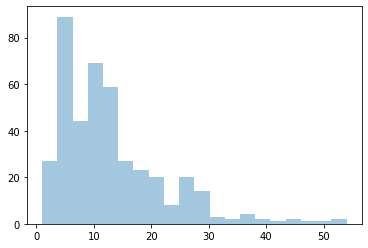

In [159]:
sns.distplot(oracle_ngrams, kde=False)

In [146]:
#sns.distplot(bin_, kde=False)

In [147]:
#sns.distplot(ensemble_score, kde=False)

In [161]:
all_files = []
for f in files_:
    with open(f'outputs/{f}', 'r') as file_:
        lines = file_.readlines()
        all_files.append(lines)

In [163]:
with open(f'outputs/ensemble_int', 'w') as ens:
    for id_, b in enumerate(bin_):
        print(b)
        ens.write(all_files[b][id_].rstrip() + '\t' + str(files_[b]) + '\n')
ens.close()

0
11
2
0
4
1
2
0
1
0
6
11
11
0
10
1
11
10
6
0
1
3
11
0
10
0
9
5
1
10
8
1
9
4
0
4
3
10
2
0
9
1
11
5
2
1
0
0
2
5
1
5
9
10
11
0
8
11
0
9
1
1
3
1
0
10
0
3
2
0
1
0
5
0
1
0
10
11
0
11
4
11
0
0
1
0
0
6
1
10
9
3
9
2
8
0
0
0
3
3
10
1
4
0
5
0
3
0
11
0
10
0
9
9
6
0
1
9
0
0
1
1
1
11
10
11
9
5
8
1
4
11
0
0
2
2
11
1
0
0
11
0
3
0
10
4
6
3
2
5
0
0
11
8
1
6
5
0
2
5
2
0
0
2
11
3
9
10
4
4
1
8
0
1
4
2
9
11
2
5
9
5
6
0
8
5
1
1
1
1
9
9
0
5
1
6
1
9
9
0
7
0
4
9
11
11
0
0
6
1
0
5
2
1
11
10
0
11
0
0
0
11
0
0
0
11
0
0
0
8
0
1
0
2
1
5
5
8
2
0
0
1
11
0
3
10
0
0
4
0
2
2
0
0
9
1
3
1
11
9
11
1
10
0
3
8
0
7
11
1
8
1
10
11
0
1
6
1
3
2
9
2
9
9
0
5
5
6
2
0
10
11
0
0
0
4
9
0
0
2
7
0
10
9
4
4
11
9
0
0
2
11
11
3
8
5
0
11
0
0
3
1
8
11
1
9
6
1
5
4
4
1
10
0
11
2
0
0
6
10
6
3
0
0
1
0
0
0
11
3
9
0
2
11
10
2
2
0
7
9
0
2
9
0
5
0
0
0
1
8
9
1
2
1
2
2
4
0
5
0
7
0
4
0
0
3
11
1
1
0
2
3
11
10
0
0
0
5
1
0
5
2
3
6
1
0
7
5
1
11
0
0
1
9
9
0
4
11


In [21]:
threshold_gold = 0
for file_ in ['lime']:
    all_revisions, first_score, final_score, improved, edits_src, edits_tgt, g_edits_src, g_edits_tgt = [], [], [], 0, [], [], [], []
    src_edits_diff, tgt_edits_diff = [],[]
    random_src, random_tgt = [], []
    gold_explanations_src, model_explanations_src, gold_explanations_tgt, model_explanations_tgt = [], [], [], []
    original, masked = [], []
    with open(f'outputs/{file_}', 'r') as out_:
        threshold = 0
        c = 0
        lines = out_.readlines()
        for threshold_expl in [0.5]:
            print(threshold_expl)
            tp_div, fp_div, fn_div, tp_eq, fp_eq, fn_eq = 0, 0, 0, 0, 0, 0 
            for line in lines:
                    if not line:
                        continue
                    c += 1
               
                    line = line.split('\t')
                    gold_a = np.array([float(x) for x in line[2].split(' ')])
                    gold_b = np.array([float(x) for x in line[3].split(' ')])
                    raw_a = np.array([float(x) for x in line[-2].split(' ')])
                    raw_b = np.array([float(x) for x in line[-1].split(' ')])
                    
                
                    gold_a_ = np.where(gold_a > threshold_gold, 1, 0)
                    gold_b_ = np.where(gold_b > threshold_gold, 1, 0)

                    expl_a_ = np.where(np.array(raw_a) < threshold_expl, 1, 0)
                    expl_b_ = np.where(np.array(raw_b) < threshold_expl, 1, 0)
                    
                    #print(f'{len(expl_b_)} {len(gold_a_)}')
                    
                    edits_src.append(np.sum(expl_a_)/len(expl_a_))
                    edits_tgt.append(np.sum(expl_b_)/len(expl_b_))
                    
                                        
                    g_edits_src.append(np.sum(gold_a_)/len(gold_a_))
                    g_edits_tgt.append(np.sum(gold_b_)/len(gold_b_))
                    
                    src_edits_diff.append(np.sum(expl_a_) - np.sum(gold_a_))
                    tgt_edits_diff.append(np.sum(expl_b_) - np.sum(gold_b_))
                    
                    gold_revisions =  num_spans(gold_b_)
                    #print(f'{revisions} {gold_revisions}')
                    #print(gold_b_)
                    #print(num_spans(gold_b_)
                    #print(expl_a_)
                    
                    gold_explanations_src.append(list(gold_a_))
                    model_explanations_src.append(list(expl_a_))
                    random_src.append(list(np.random.randint(2, size=len(list(gold_a_)))))

                    gold_explanations_tgt.append(list(gold_b_))
                    model_explanations_tgt.append(list(expl_b_))
                    random_tgt.append(list(np.random.randint(2, size=len(list(gold_b_)))))

                    text_a = line[0].split(' ')
                    text_b = line[1].split(' ')

     

            rec_src, all_recall_src = compute_rec_topk(gold_explanations_src, model_explanations_src, pos=[])
            ap_src, all_precision_src = compute_ap_score(gold_explanations_src, model_explanations_src, pos=[])

            rec_tgt, all_recall_tgt = compute_rec_topk(gold_explanations_tgt, model_explanations_tgt, pos=[])
            ap_tgt, all_precision_tgt = compute_ap_score(gold_explanations_tgt, model_explanations_tgt, pos=[])
            print(f'\n ---{file_}')
            print(f'\n{ap_src}')
            print(f'{rec_src}')

            print(f'\n{ap_tgt}')
            print(f'{rec_tgt}')
            
            random_rec_src,_  = compute_rec_topk(gold_explanations_src, random_src, pos=[])
            random_rec_tgt,_  = compute_rec_topk(gold_explanations_tgt, random_tgt, pos=[])
            random_ap_src, _ = compute_ap_score(gold_explanations_src, random_src, pos=[])
            random_ap_tgt, _ = compute_ap_score(gold_explanations_tgt, random_tgt, pos=[])


print(f'Src Edits: {np.mean(edits_src)*100}')
print(f'Tgt Edits: {np.mean(edits_tgt)*100}')

print(f'\nSrc Gold: {np.mean(g_edits_src)*100}')
print(f'Tgt Gold: {np.mean(g_edits_tgt)*100}')

print(f'\nSrc Diff: {np.mean(src_edits_diff)} {np.std(src_edits_diff)} ')
print(f'Tgt Diff: {np.mean(tgt_edits_diff)} {np.std(tgt_edits_diff)}')

#print(f'{ap_src}\t{rec_src}\t{ap_tgt}\t{rec_tgt}\t{equivalized*100}\t{100*improved/len(final_score)}\t{np.mean(all_revisions)}\t{np.mean(edits_src)*100}\t{np.mean(edits_src)*100}')

0.5

 ---lime

0.3884163501603609
0.8936014078613141

0.4259962602647194
0.9046922147380578
Src Edits: 88.4237504247101
Tgt Edits: 89.06958653346206

Src Gold: 38.766756076068084
Tgt Gold: 43.13676100198293

Src Diff: 14.787081339712918 9.781836776182267 
Tgt Diff: 14.916267942583731 10.299355368176064


In [13]:
len(gold_explanations_src)

418

In [12]:
len(model_explanations_src)

418